# Задача

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет температуру стали.

# Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

##  data_arc

Таблица data_arc результаты предобработки:
- пропусков нет, к надлежащему типу данные приведены
- нужно агрегировать данные по каждой партии: суммировать мощности и найти общее время нагрева. Или посчитать работу. Можно попробовать оба варианта, и посмотреть как они влияют на обучение модели.
- есть выбросы (по результатам построения boxplot): в столбце Время нагрева (больше 4 минут), Активной мощности (больше 1.5) и Реактивной мощности (больше 1.2). Я их оставлю, так как значений сравнительно мало и они менее чем в 2 раза отличаются от верхнего квартиля данных. То есть, на мой взгляд, они и выглядят правдиво, и модель не запутают.

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [3]:
#Перевожу данные 2х столбцов в тип дата-время
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.info()
data_arc.head()
data_arc['Начало нагрева дугой'].is_monotonic

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


False

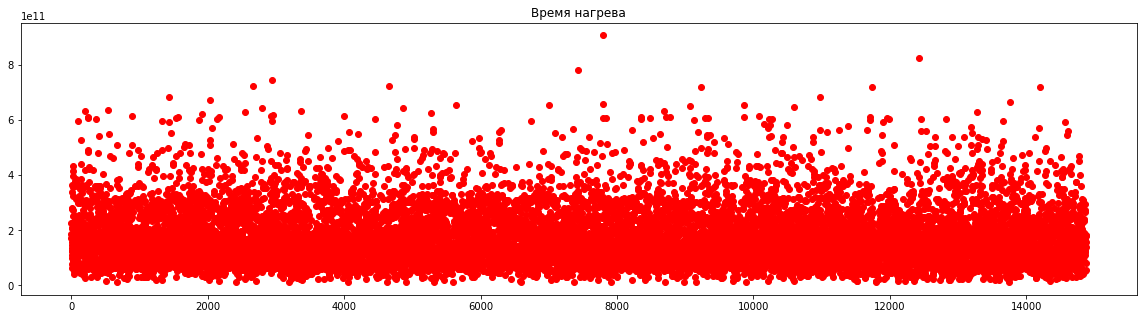

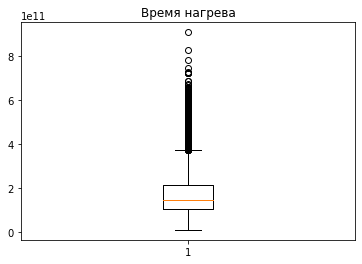

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28


In [4]:
#Создаю и проверяю значения из столбца Время нагрева
plt.figure(figsize=(20, 5))
data_arc['Время нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
plt.plot(data_arc['Время нагрева'], 'ro')
plt.title('Время нагрева')
plt.show()
plt.boxplot(data_arc['Время нагрева'].values)
plt.title('Время нагрева')
plt.show()

data_arc.head()

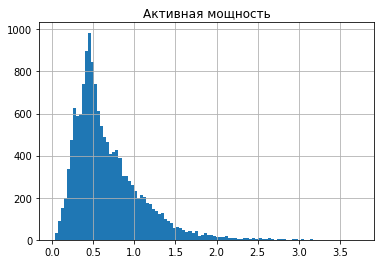

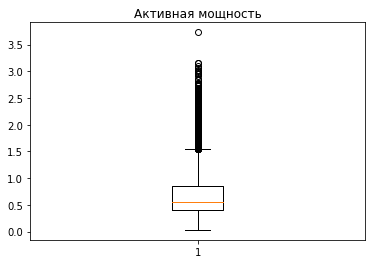

In [5]:
#Смотрю значения из столбца Активная мощность
data_arc['Активная мощность'].hist(bins=100)
plt.title('Активная мощность')
plt.show()
plt.boxplot(data_arc['Активная мощность'].values)
plt.title('Активная мощность')
plt.show()

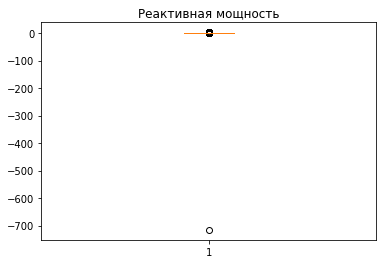

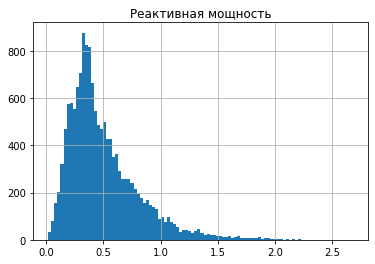

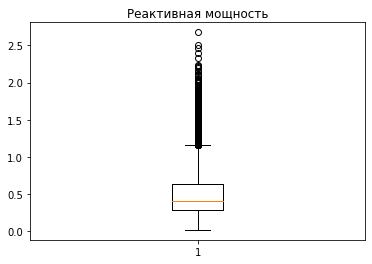

In [6]:
#Смотрю значения из столбца Реактивная мощность

plt.boxplot(data_arc['Реактивная мощность'].values)
plt.title('Реактивная мощность')
plt.show()
#Удаляю явный выброс со значением мощности -700
data_arc = data_arc.drop(data_arc[data_arc['Реактивная мощность'] < -100].index)

data_arc['Реактивная мощность'].hist(bins=100)
plt.title('Реактивная мощность')
plt.show()
plt.boxplot(data_arc['Реактивная мощность'].values)
plt.title('Реактивная мощность')
plt.show()

## data_bulk

Таблица data_bulk результаты предобработки:
- пропуски занимают большую часть таблицы. Столбцы с количеством значений менее 20 были удалены, в остальных пропуски заменены на 0
- удалена 1 строка с аномально большими значениями bulk в нескольких столбцах

In [7]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Bulk 1


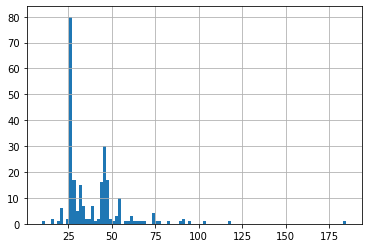

Bulk 2


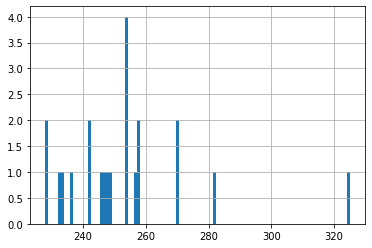

Bulk 3


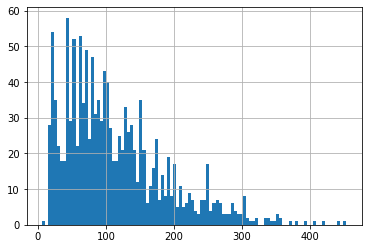

Bulk 4


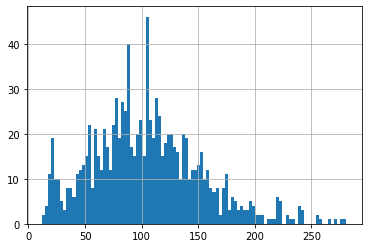

Bulk 5


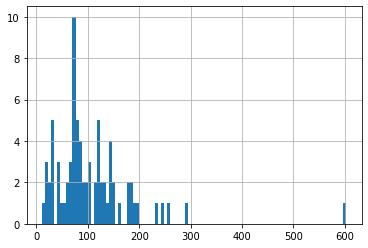

Bulk 6


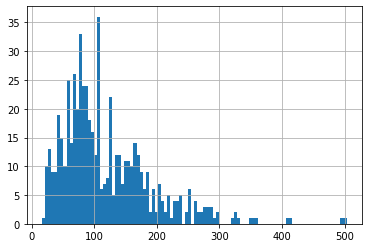

Bulk 7


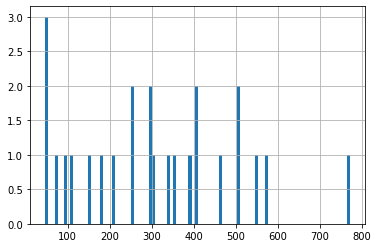

Bulk 8


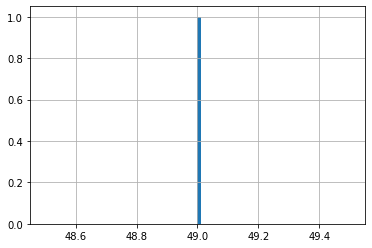

Bulk 9


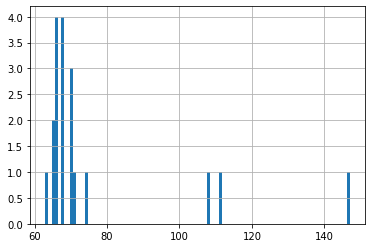

Bulk 10


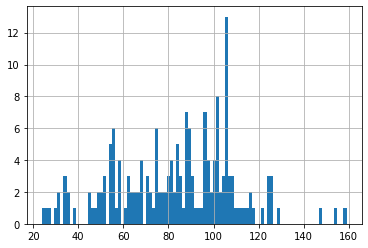

Bulk 11


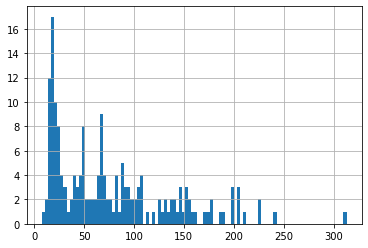

Bulk 12


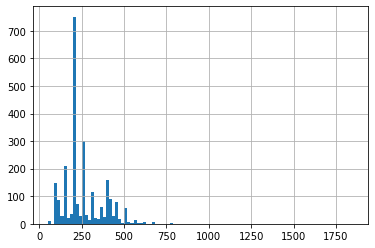

Bulk 13


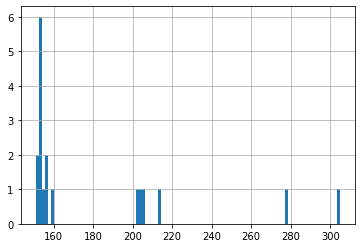

Bulk 14


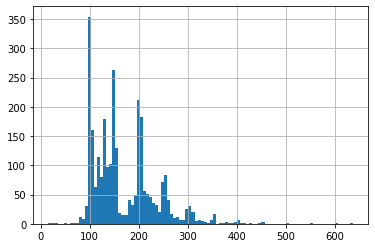

Bulk 15


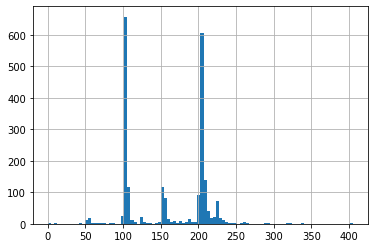

In [8]:
for i in range(1, 16):
    print('Bulk {}'.format(i))
    data_bulk['Bulk {}'.format(i)].hist(bins=100)
    plt.show()

In [9]:
#Найдены несколько аномально боьших значений, и все в одной строке
display(data_bulk.loc[data_bulk['Bulk 1'] > 150])
display(data_bulk.loc[data_bulk['Bulk 12'] > 1000])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


In [10]:
#Удаляю столбцы с наибольшим количеством пропусков. Заменяю пропуски на 0
data_bulk = data_bulk.drop(['Bulk 8', 'Bulk 9', 'Bulk 13'], axis=1)
data_bulk = data_bulk.fillna(value=0)
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 13 columns):
key        3129 non-null int64
Bulk 1     3129 non-null float64
Bulk 2     3129 non-null float64
Bulk 3     3129 non-null float64
Bulk 4     3129 non-null float64
Bulk 5     3129 non-null float64
Bulk 6     3129 non-null float64
Bulk 7     3129 non-null float64
Bulk 10    3129 non-null float64
Bulk 11    3129 non-null float64
Bulk 12    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(12), int64(1)
memory usage: 317.9 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


## data_gas

Таблица data_gas результаты предобработки:
- пропусков нет, тип данных адекватный
- удалены аномальные значения более 50, так как они заметно превышают верхний квартиль boxplot

In [11]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


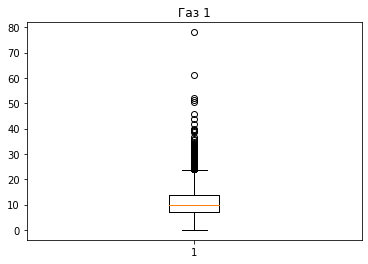

In [12]:
plt.boxplot(data_gas['Газ 1'].values)
plt.title('Газ 1')
plt.show()

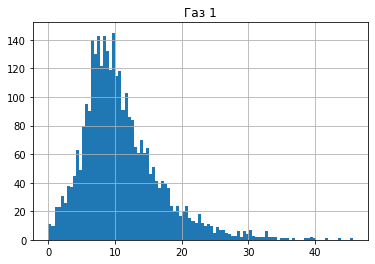

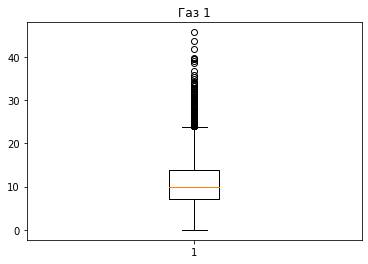

In [13]:
data_gas = data_gas[data_gas['Газ 1'] < 50]

data_gas['Газ 1'].hist(bins=100)
plt.title('Газ 1')
plt.show()

plt.boxplot(data_gas['Газ 1'].values)
plt.title('Газ 1')
plt.show()

## data_temp

Таблица data_temp результаты предобработки:
- строки с пропусками в значении температуры удалены
- в таблице data_temp_last оставлены только окончательные измерения температуры - это целевой признак
- в таблице data_temp_first первые замеры температуры
- из обеих таблиц были удалены несколько аномальных значений (первая температура - до 1300 градусов, последняя температура - более 1680 градусов)
- примерно в трети случаев температура после обработки стала ниже, чем была. Распределение разницы температур похоже на нормальное (и оно симметрично относительно нуля), то есть, видимо, это вписывется в физику процесса

In [14]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [15]:
#Удаляю строчки с пропусками в температуре и строчки с одним и менее измерением для всей партии
data_temp = data_temp.dropna()
value_temp = data_temp['key'].value_counts()
value_temp = value_temp[value_temp > 1]
data_temp = data_temp[data_temp['key'].isin(value_temp.index)]
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 0 to 12266
Data columns (total 3 columns):
key             12265 non-null int64
Время замера    12265 non-null datetime64[ns]
Температура     12265 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [16]:
data_temp_last = data_temp.drop_duplicates(subset=['key'], keep='last')
data_temp_last.info()
data_temp_last.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 4 to 12266
Data columns (total 3 columns):
key             2475 non-null int64
Время замера    2475 non-null datetime64[ns]
Температура     2475 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.3 KB


,key,Время замера,Температура
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0


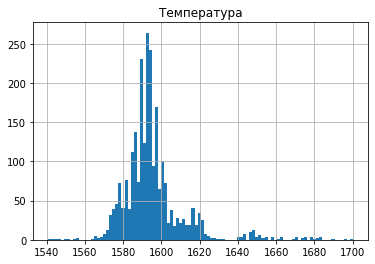

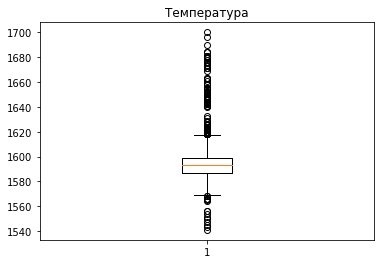

In [17]:
data_temp_last['Температура'].hist(bins=100)
plt.title('Температура')
plt.show()
plt.boxplot(data_temp_last['Температура'].values)
plt.title('Температура')
plt.show()

In [18]:
data_temp_first = data_temp.drop_duplicates(subset=['key'], keep='first')
data_temp_first.info()
data_temp_first.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 12264
Data columns (total 3 columns):
key             2475 non-null int64
Время замера    2475 non-null datetime64[ns]
Температура     2475 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 77.3 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
5,2,2019-05-03 11:37:27,1581.0
11,3,2019-05-03 12:13:17,1596.0
16,4,2019-05-03 12:52:57,1601.0
19,5,2019-05-03 13:23:19,1576.0


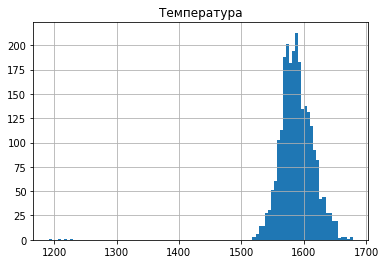

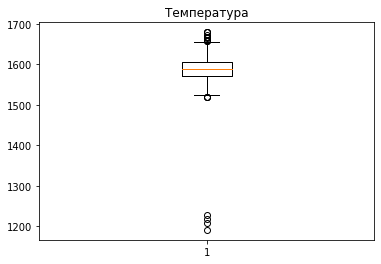

In [19]:
data_temp_first['Температура'].hist(bins=100)
plt.title('Температура')
plt.show()
plt.boxplot(data_temp_first['Температура'].values)
plt.title('Температура')
plt.show()

,key,Время замера_x,Температура_x,Время замера_y,Температура_y,diff_temp,diff_time
10,11,2019-05-03 16:54:18,1616.0,2019-05-03 17:27:23,1597.0,-19.0,00:33:05
11,12,2019-05-03 17:40:54,1606.0,2019-05-03 18:13:03,1591.0,-15.0,00:32:09
14,15,2019-05-03 20:58:40,1605.0,2019-05-03 21:33:01,1598.0,-7.0,00:34:21
16,17,2019-05-03 22:42:34,1611.0,2019-05-03 23:10:16,1599.0,-12.0,00:27:42
18,19,2019-05-04 00:39:51,1625.0,2019-05-04 01:19:06,1597.0,-28.0,00:39:15
...,...,...,...,...,...,...,...
2460,2484,2019-08-05 12:40:56,1635.0,2019-08-05 13:09:33,1592.0,-43.0,00:28:37
2464,2488,2019-08-05 19:20:14,1602.0,2019-08-05 19:55:29,1577.0,-25.0,00:35:15
2465,2489,2019-08-05 20:30:10,1613.0,2019-08-05 21:02:41,1579.0,-34.0,00:32:31
2467,2492,2019-08-05 22:41:41,1618.0,2019-08-05 23:19:44,1595.0,-23.0,00:38:03


,key,Время замера_x,Температура_x,Время замера_y,Температура_y,diff_temp,diff_time


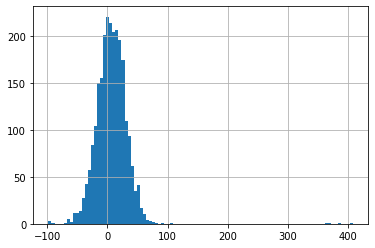

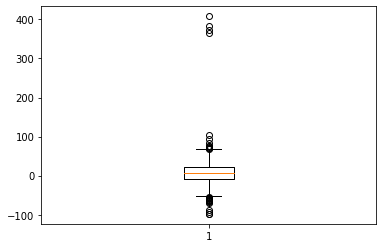

In [20]:
#проверяю на адекватность начальные и конечные температуры
temp = data_temp_first.merge(data_temp_last, on='key', how='outer')
temp['diff_temp'] = temp['Температура_y'] - temp['Температура_x']
temp['diff_time'] = temp['Время замера_y'] - temp['Время замера_x']
display(temp[temp['diff_temp'] <= 0])
display(temp[temp['diff_time'] <= '00:00:10'])
temp['diff_temp'].hist(bins=100)
plt.show()
plt.boxplot(temp['diff_temp'])
plt.show()

In [21]:
#удаляю партии, где разница между начальным и конечным значением большее 300 градусов - это выбросы
temp_del = temp[temp['diff_temp'] < 300]
data_temp_first = data_temp_first[data_temp_first['key'].isin(temp_del.key)]
data_temp_last = data_temp_last[data_temp_last['key'].isin(temp_del.key)]
temp[temp['diff_temp'] > 300]

,key,Время замера_x,Температура_x,Время замера_y,Температура_y,diff_temp,diff_time
853,867,2019-06-04 14:21:00,1191.0,2019-06-04 14:57:17,1599.0,408.0,00:36:17
1199,1214,2019-06-16 05:32:00,1208.0,2019-06-16 06:14:45,1591.0,383.0,00:42:45
1602,1619,2019-06-30 11:03:54,1218.0,2019-06-30 11:21:54,1590.0,372.0,00:18:00
2034,2052,2019-07-21 14:51:40,1227.0,2019-07-21 15:24:06,1592.0,365.0,00:32:26


Разница между начальной и конечной температурой в 4 раза превышает верхний квартиль boxplot. И указанные значения отстоят от остальных через заметный промежуток. Возможно, была ошибка в измерении начальной температуры. Так же указанные темперауры ниже температур плавления стали

In [22]:
#Удаляю аномальные значения из конечной температуры (>1680 градусов)
data_temp_last = data_temp_last[data_temp_last['Температура'] < 1680]
temp_last_del = data_temp_last[data_temp_last['Температура'] < 1680]
data_temp_first = data_temp_first[data_temp_first['key'].isin(temp_last_del.key)]
data_temp_first.info()
data_temp_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2462 entries, 0 to 12264
Data columns (total 3 columns):
key             2462 non-null int64
Время замера    2462 non-null datetime64[ns]
Температура     2462 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 76.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2462 entries, 4 to 12266
Data columns (total 3 columns):
key             2462 non-null int64
Время замера    2462 non-null datetime64[ns]
Температура     2462 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 76.9 KB


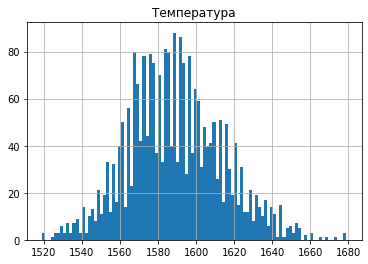

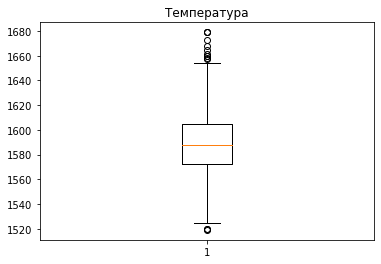

In [23]:
data_temp_first['Температура'].hist(bins=100)
plt.title('Температура')
plt.show()
plt.boxplot(data_temp_first['Температура'].values)
plt.title('Температура')
plt.show()

## data_wire

Таблица data_wire результаты предобработки:
- пропуски занимают большую часть таблицы. Столбцы с количеством значений менее 15 были удалены, в остальных пропуски заменены на 0

In [24]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wire 1


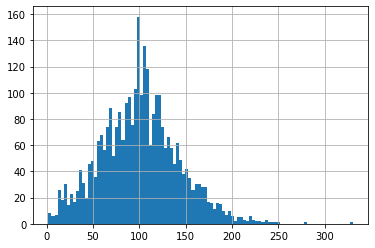

Wire 2


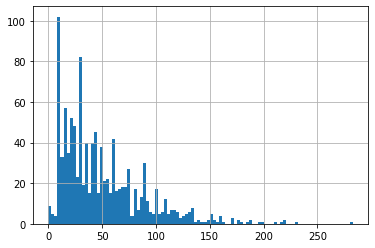

Wire 3


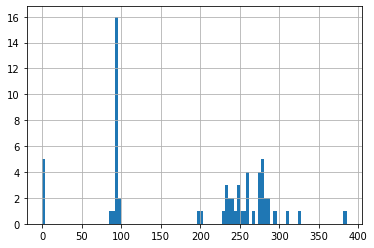

Wire 4


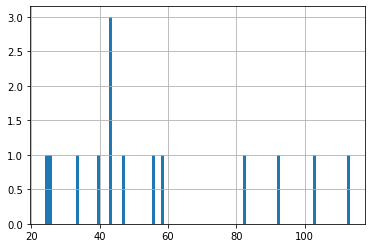

Wire 5


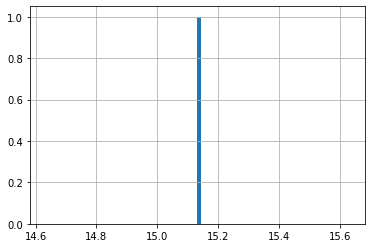

Wire 6


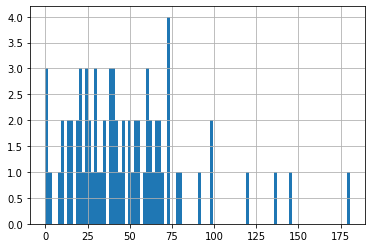

Wire 7


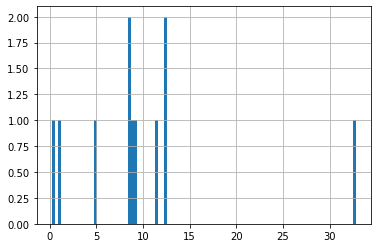

Wire 8


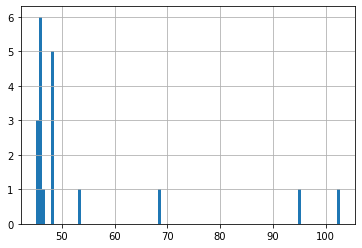

Wire 9


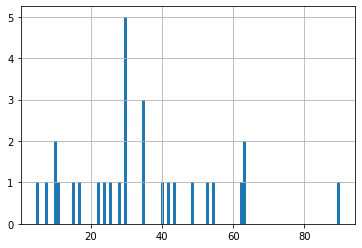

In [25]:
for i in range(1, 10):
    print('Wire {}'.format(i))
    data_wire['Wire {}'.format(i)].hist(bins=100)
    plt.show()

In [26]:
display(data_wire.loc[data_wire['Wire 7'] > 30])
display(data_wire.loc[data_wire['Wire 9'] > 80])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2436,2563,5.11056,NaN,93.165077,NaN,NaN,53.196003,32.847674,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
901,961,55.177196,70.122002,NaN,NaN,NaN,NaN,NaN,NaN,90.053604


In [27]:
#Удаляю столбцы с наибольшим количеством пропусков. Заменяю пропуски на 0
data_wire = data_wire.drop(['Wire 4', 'Wire 5', 'Wire 7'], axis=1)
data_wire = data_wire.fillna(value=0)
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 7 columns):
key       3081 non-null int64
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 6    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(6), int64(1)
memory usage: 168.6 KB


,key,Wire 1,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0


## data_wire_time / data_bulk_time

Таблицы data_wire_time и data_bulk_time результаты предобработки:
- значения переведены в тип дата-время для сравнения с таблицей времени измерения температуры
- удалены партии, в которых замеры конечной температуры были проведены ранее последнего изменения состава

In [28]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
   
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire_time = data_wire_time.merge(data_temp_last, on='key', how='right').fillna(value=0)

#Перевожу данные столбцов в тип дата-время и проверяю наличие времени введения добавок
#после последнего измерения температуры
data_wire_time['Res_sum'] = False
for i in range(1, 10):
    data_wire_time['Wire {}'.format(i)] = pd.to_datetime(data_wire_time['Wire {}'.format(i)])
    data_wire_time['Res_sum'] += data_wire_time['Wire {}'.format(i)] > data_wire_time['Время замера']

data_del = data_wire_time[data_wire_time['Res_sum'] == True]
data_del

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Время замера,Температура,Res_sum
1173,1244,2019-06-17 08:33:55,2019-06-17 08:49:29,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,2019-06-17 08:45:16,1593.0,True
1430,1505,2019-06-26 14:14:50,2019-06-26 14:18:01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,1970-01-01,2019-06-26 14:14:29,1629.0,True


In [30]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [31]:
data_bulk_time = data_bulk_time.merge(data_temp_last, on='key', how='right').fillna(value=0)

#Перевожу данные столбцов в тип дата-время и проверяю наличие времени введения добавок
#после последнего измерения температуры
data_bulk_time['Res_sum'] = False
for i in range(1, 16):
    data_bulk_time['Bulk {}'.format(i)] = pd.to_datetime(data_bulk_time['Bulk {}'.format(i)])
    data_bulk_time['Res_sum'] += data_bulk_time['Bulk {}'.format(i)] > data_bulk_time['Время замера']

data_del = data_del.merge(data_bulk_time[data_bulk_time['Res_sum'] == True], how='outer')
data_bulk_time[data_bulk_time['Res_sum'] == True]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Время замера,Температура,Res_sum
554,586,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-05-25 01:29:11,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,2019-05-25 01:28:18,1594.0,True
1190,1244,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-06-17 08:49:23,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,2019-06-17 08:45:16,1593.0,True
1260,1316,1970-01-01,1970-01-01,2019-06-19 17:35:26,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,2019-06-19 17:34:42,1595.0,True
1434,1493,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,2019-06-26 06:51:49,1970-01-01 00:00:00,2019-06-26 05:56:51,1970-01-01,2019-06-26 05:56:51,2019-06-26 05:56:51,2019-06-26 06:47:47,1590.0,True
1446,1505,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,2019-06-26 14:17:30,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,2019-06-26 14:14:29,1629.0,True
1486,1549,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-06-28 05:33:18,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01 00:00:00,1970-01-01,2019-06-28 05:17:08,1970-01-01 00:00:00,2019-06-28 05:32:46,1589.0,True
1803,1873,1970-01-01,1970-01-01,2019-07-08 22:13:14,1970-01-01 00:00:00,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,2019-07-08 21:39:55,1970-01-01,2019-07-08 21:39:55,2019-07-08 21:39:55,2019-07-08 22:09:51,1594.0,True
2056,2137,1970-01-01,1970-01-01,2019-07-24 16:34:32,2019-07-24 16:53:54,1970-01-01,1970-01-01 00:00:00,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:00:00,2019-07-24 16:24:28,1970-01-01,2019-07-24 16:24:28,2019-07-24 16:24:28,2019-07-24 16:53:42,1585.0,True
2324,2421,1970-01-01,1970-01-01,2019-08-03 08:55:29,1970-01-01 00:00:00,1970-01-01,2019-08-03 08:55:29,1970-01-01,1970-01-01,1970-01-01,1970-01-01 00:00:00,2019-08-03 09:06:24,1970-01-01 00:00:00,1970-01-01,2019-08-03 08:49:32,1970-01-01 00:00:00,2019-08-03 09:06:23,1578.0,True


In [32]:
#Были найдены 9 партий, в которых конечная температура измерялась ДО последнего изменения состава
#Удаляю их
data_temp_first = data_temp_first.drop(data_temp_first[data_temp_first['key'].isin(data_del.key)].index)
data_temp_last = data_temp_last.drop(data_temp_last[data_temp_last['key'].isin(data_del.key)].index)

data_temp_first.info()
data_temp_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 0 to 12264
Data columns (total 3 columns):
key             2453 non-null int64
Время замера    2453 non-null datetime64[ns]
Температура     2453 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 76.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2453 entries, 4 to 12266
Data columns (total 3 columns):
key             2453 non-null int64
Время замера    2453 non-null datetime64[ns]
Температура     2453 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 76.7 KB


# Подготовка признаков

## Таблица с признаками

Формирование признаков:
Я решила оставить из первой таблицы 2 признака: время нагрева и активную мощность.Так как "реактивная мощность это мощность, которая не была передана в нагрузку, а привела к потерям на нагрев и излучение". То есть на температуру стали она влияния не оказывает, и является характеристикой нагревающей системы.

In [33]:
#Суммирую значения активной мощности и Время нагрева
data_arc_sum_1 = data_arc.pivot_table(index=['key'], values=['Активная мощность'], aggfunc='sum')
data_arc_sum_2 = data_arc.pivot_table(index=['key'], values=['Время нагрева'], aggfunc='sum')
data_sum = data_arc_sum_1.join(data_arc_sum_2, on='key', how='outer')

#Объединяю таблицы
#Так много строк, потому что join одновременно много таблиц объединяет только по индексу
data_temp_first.columns = ['key', 'Время замера', 'Начальная температура']
features = data_temp_first[['key', 'Начальная температура']].merge(data_sum, on='key', how='left')
features = features.merge(data_bulk, on='key', how='left')
features = features.merge(data_gas, on='key', how='left')
features = features.merge(data_wire, on='key', how='left')

#Удаляю строки с пропусками, так как они соответствуют партиям с измеренной температурой,
#но без количества газа для продувки и информации о добавках
features.index = features.key
features = features.dropna().drop(['key'], axis=1)
features['Время нагрева'] = features['Время нагрева'].astype('int')
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 1 to 2499
Data columns (total 22 columns):
Начальная температура    2312 non-null float64
Активная мощность        2312 non-null float64
Время нагрева            2312 non-null int64
Bulk 1                   2312 non-null float64
Bulk 2                   2312 non-null float64
Bulk 3                   2312 non-null float64
Bulk 4                   2312 non-null float64
Bulk 5                   2312 non-null float64
Bulk 6                   2312 non-null float64
Bulk 7                   2312 non-null float64
Bulk 10                  2312 non-null float64
Bulk 11                  2312 non-null float64
Bulk 12                  2312 non-null float64
Bulk 14                  2312 non-null float64
Bulk 15                  2312 non-null float64
Газ 1                    2312 non-null float64
Wire 1                   2312 non-null float64
Wire 2                   2312 non-null float64
Wire 3                   2312 non-null float64
Wi

,Начальная температура,Активная мощность,Время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,4.878147,1098000000000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0
2,1581.0,3.052598,811000000000,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0
3,1596.0,2.525882,655000000000,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0
4,1601.0,3.209250,741000000000,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0
5,1576.0,3.347173,869000000000,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0


## Корреляция признаков

In [34]:
corr = features.corr()
corr[(corr<-0.5) | (corr>0.5)]

,Начальная температура,Активная мощность,Время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9
Начальная температура,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Активная мощность,NaN,1.000000,0.978033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Время нагрева,NaN,0.978033,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.731926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54696,NaN,NaN
Bulk 3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 7,NaN,NaN,NaN,NaN,0.731926,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Корреляция между признаками в основном меньше 0.5. Есть корреляция около 0.6 и 0.7 между некоторым количеством добавок, например, между Bulk 2 и Bulk 7. Возможно, это связано с определенным соотношением добавок для достижения химического состава стали. Я оставлю все признаки с количеством добавок.

Время нагрева очень сильно коррелирует с активной мощностью (коэффициент корреляции 0.98). Я удалю время нагрева из признаков, действительно, мощность уже включает в себя время нагрева

In [35]:
features = features.dropna().drop(['Время нагрева'], axis=1)
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 1 to 2499
Data columns (total 21 columns):
Начальная температура    2312 non-null float64
Активная мощность        2312 non-null float64
Bulk 1                   2312 non-null float64
Bulk 2                   2312 non-null float64
Bulk 3                   2312 non-null float64
Bulk 4                   2312 non-null float64
Bulk 5                   2312 non-null float64
Bulk 6                   2312 non-null float64
Bulk 7                   2312 non-null float64
Bulk 10                  2312 non-null float64
Bulk 11                  2312 non-null float64
Bulk 12                  2312 non-null float64
Bulk 14                  2312 non-null float64
Bulk 15                  2312 non-null float64
Газ 1                    2312 non-null float64
Wire 1                   2312 non-null float64
Wire 2                   2312 non-null float64
Wire 3                   2312 non-null float64
Wire 6                   2312 non-null float64


,Начальная температура,Активная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 10,...,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,4.878147,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0
2,1581.0,3.052598,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0
3,1596.0,2.525882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0
4,1601.0,3.209250,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0
5,1576.0,3.347173,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0


## Таблица с целевым признаком

In [36]:
target = data_temp_last[['key', 'Температура']]
target.index = target.key
target = target[['Температура']]

#Удалила из целевого признака партии, которых нет в таблице с признаками
target = target[target.index.isin(features.index)]
target.info()
target.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 1 to 2499
Data columns (total 1 columns):
Температура    2312 non-null float64
dtypes: float64(1)
memory usage: 36.1 KB


,Температура
key,
1,1613.0
2,1602.0
3,1599.0
4,1625.0
5,1602.0


## Разделение данных на обучающую, валидационную и тестовую выборки

In [37]:
features_train, features_, target_train, target_ = train_test_split(features, target, test_size=0.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_, target_, test_size=0.5, random_state=42)

print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(1387, 21) (462, 21) (463, 21)
(1387, 1) (462, 1) (463, 1)


# Обучение моделей

## Линейная регрессия

In [38]:
model1 = LinearRegression()
model1.fit(features_train, target_train)
mean_absolute_error(target_valid, model1.predict(features_valid))

5.861835063903411

## Дерево

7 6.885371418189369


Text(0, 0.5, 'mae')

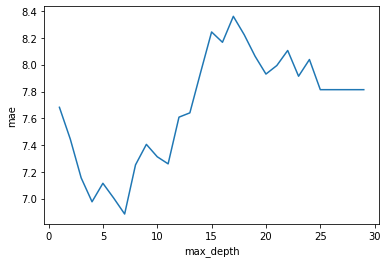

In [39]:
n_list = []
mae_list = []
mae_min = 100
for n in range(1, 30):
    
    model = DecisionTreeRegressor(random_state=42, max_depth=n)
    model.fit(features_train, target_train)
    mae = mean_absolute_error(target_valid, model.predict(features_valid))
    
    n_list.append(n)
    mae_list.append(mae)

    if mae < mae_min:
        mae_min = mae
        n_min = n
        
print(n_min, mae_min) 

model2 = DecisionTreeRegressor(random_state=42, max_depth=n_min)

plt.plot(n_list, mae_list)
plt.xlabel('max_depth')
plt.ylabel('mae')

## Случайный лес

95 5.8811853242589605


Text(0, 0.5, 'mae')

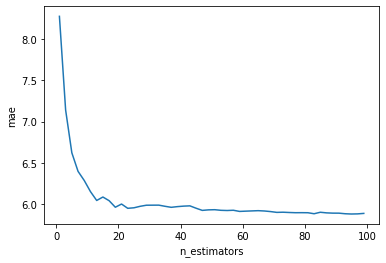

In [40]:
n_list = []
mae_list = []
mae_min = 100

for n in range(1, 100, 2):
    
    model = RandomForestRegressor(random_state=42, n_estimators=n, max_depth=20)
    model.fit(features_train, target_train)
    mae = mean_absolute_error(target_valid, model.predict(features_valid))
    
    n_list.append(n)
    mae_list.append(mae)

    if mae < mae_min:
        mae_min = mae
        n_min = n
        
print(n_min, mae_min)

model3_n_est = n_min

plt.plot(n_list, mae_list)
plt.xlabel('n_estimators')
plt.ylabel('mae')

9 5.824179715470999


Text(0, 0.5, 'mae')

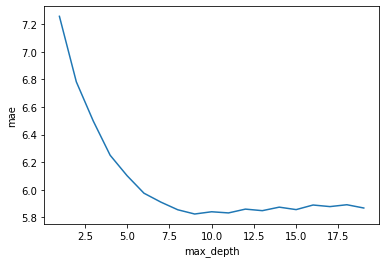

In [41]:
n_list = []
mae_list = []
mae_min = 100

for n in range(1, 20):
    
    model = RandomForestRegressor(random_state=42, n_estimators=model3_n_est, max_depth=n)
    model.fit(features_train, target_train)
    mae = mean_absolute_error(target_valid, model.predict(features_valid))
    
    n_list.append(n)
    mae_list.append(mae)

    if mae < mae_min:
        mae_min = mae
        n_min = n
        
print(n_min, mae_min)   

model3 = RandomForestRegressor(random_state=42, n_estimators=model3_n_est, max_depth=n_min)

plt.plot(n_list, mae_list)
plt.xlabel('max_depth')
plt.ylabel('mae')

# Анализ моделей

In [42]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_train)
mae0 = mean_absolute_error(target_test, dummy.predict(features_test))

In [43]:
model1.fit(features_train, target_train)
mae1 = mean_absolute_error(target_test, model1.predict(features_test))

model2.fit(features_train, target_train)
mae2 = mean_absolute_error(target_test, model2.predict(features_test))

model3.fit(features_train, target_train)
mae3 = mean_absolute_error(target_test, model3.predict(features_test))

In [44]:
scaler = StandardScaler()
num = features_train.columns
scaler.fit(features_train[num])
features_train_m = features_train.copy()
features_test_m = features_test.copy()
features_train_m[num] = scaler.transform(features_train_m[num])
features_test_m[num] = scaler.transform(features_test_m[num])

model3.fit(features_train_m, target_train)
mae4 = mean_absolute_error(target_test, model3.predict(features_test_m))

In [45]:
columns = ['Модель', 'MAE']
name = ['Среднее', 'Линейная регрессия', 'Дерево', 'Случайный лес', 'Случайный лес с масштабированием']
mae = [mae0, mae1, mae2, mae3, mae4]
results = pd.DataFrame([name, mae], columns)
display(results)

,0,1,2,3,4
Модель,Среднее,Линейная регрессия,Дерево,Случайный лес,Случайный лес с масштабированием
MAE,8.18397,6.26418,7.15051,6.1373,6.13473


Лучший результат показала модель случайного леса (с гиперпараметрами: максимальная глубина 9, количество деревьев 95) МАЕ 6.14 градуса. Линейная регрессия тоже дала хороший результат - 6.26 градуса.

Предварительное масштабирование признаков ошибку практически не изменило

## Анализ важности признаков

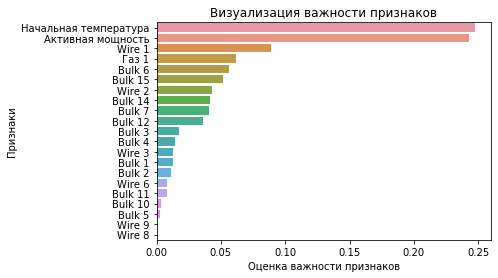

In [46]:
import seaborn as sns

def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model3)

По оценке важности: самый значимый признак это начальная температура, что логично, так как сталь нагревается именно от этой температуры. Активная мощность тоже непосредственно влияет на конечную температуру, так как это энергия, которая подается стали во время обработки.

Важнее объема газа оказались добавки проволки Wire 1. Так же добавки, подаваемые в большее число партий оказываются важнее, чем добавки, которые почти никуда не подаются. Это тоже логично (добавки, наверное, охлаждают сталь), и оправдывает то, что я во время обработки удаляла совсем малочисленные добавки (можно было бы еще больше удалить).

# Вывод

В ходе данной работы была разработана модель, предсказывающая температуру стали после обработки. Для обучения и проверки модели был составлен набор признаков из характеристик производственного процесса обработки стали.

Лучший результат показала модель случайного леса (с гиперпараметрами: максимальная глубина 9, количество деревьев 95) МАЕ 6.14 градуса. Это значение заметно меньше результата для константной модели (МАЕ 8.2 градуса), а значит, модель прошла проверку на адекватность.

Наиболее важными факторами, влияющими на конечную температуру стали оказались: начальная температура, активная мощность и объем добавок Wire 1.